In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os

os.environ[
    "CUDA_VISIBLE_DEVICES"
] = "-1"  # this line tells TensorFlow not to use any GPU
# Basics
# Basics
import tensorflow as tf
import xarray as xr
import random

# Helpful
import tqdm

# Visualization
import matplotlib.pyplot as plt

# Path setup
import sys

sys.path.append("/home/dchen/BA_CH_EN/")


# My Methods
from src.utils.CRPS import *  # CRPS metrics
from src.utils.data_split import *  # Splitting data into X and y
from src.utils.drn_make_X_array import *  # Import make train array functions (make_X_array)
from src.models.EMOS import *  # EMOS implementation
from src.models.EMOS_global.EMOS_global_load_score import *  # Load EMOS_global_scores
from src.models.EMOS_global.EMOS_global_load_model import *  # Load EMOS_global_models
from src.models.EMOS_local.EMOS_local_load_score import *  # Load EMOS_local_scores
from src.models.EMOS_local.EMOS_local_load_model import *  # Load EMOS_local_models
from src.models.DRN.DRN_model import *  # DRN implementation
from src.models.DRN.DRN_load_score import *  # Load DRN_scores
from src.models.DRN.DRN_load_score_10 import *  # Load DRN_scores_10
from src.models.DRN.DRN_load_score_dummy_10 import *  # Load DRN_scores_10
import data.raw.load_data_raw as ldr  # Load raw data
import data.processed.load_data_processed as ldp  # Load processed data normed
import data.processed.load_data_processed_denormed as ldpd  # Load processed data denormed
from src.models.CRPS_baseline.CRPS_load import *  # Load CRPS scores
from src.models.U_net.u_net_load_score import *
from src.models.U_net.u_net_load_preds import *

<IPython.core.display.Javascript object>

### 0. Set up

In [3]:
lead_time = 11
var_num = 2

<IPython.core.display.Javascript object>

### 1. Loading

#### 1.1 Load Data

In [27]:
# Define the names of the variables
var_names = ["u10", "v10", "t2m", "t850", "z500", "ws10"]


# Load all test data of each variable
test_var_denormed = ldpd.load_data_all_test_proc_denorm()

# Split the loaded data into features (X) and target (y)
dat_X_test_lead_all_denorm, dat_y_test_lead_all_denorm = split_var_lead(
    test_var_denormed
)

# Preprocess the features for Neural Network and scale them
drn_X_test_lead_array, drn_embedding_test_lead_array = make_X_array(
    dat_X_test_lead_all_denorm, lead_time
)

drn_X_test_lead_array_reshaped = drn_X_test_lead_array.reshape(357, 120, 130, 12)
drn_embedding_test_lead_array_reshaped = drn_embedding_test_lead_array.reshape(
    357, 120, 130
)
# Reshape target values into a 1D array
t2m_y_test_reshaped = dat_y_test_lead_all_denorm[var_num][lead_time].values

<IPython.core.display.Javascript object>

#### 1.2 Load Model

In [19]:
# Load the trained model to use:
path = f"/Data/Delong_BA_Data/models/DRN/DRN_{var_names[var_num]}_lead_time_{lead_time}_denormed.h5"
DRN_model = tf.keras.models.load_model(
    path,
    custom_objects={
        "crps_cost_function": crps_cost_function,
        "crps_cost_function_trunc": crps_cost_function_trunc,
    },
)

<IPython.core.display.Javascript object>

#### 1.3 Load Original Score

In [30]:
DRN_scores_t2m_dummy_10 = DRN_load_score_dummy_10("t2m")

<IPython.core.display.Javascript object>

In [35]:
DRN_scores_t2m_dummy_10[lead_time][0, 0]

0.5471469141021699

<IPython.core.display.Javascript object>

In [94]:
# Add dummy variable for land sea mask
land_sea_mask_dummy = np.load(
    "/Data/Delong_BA_Data/land_sea_mask_dummy/land_sea_mask_dummy.npy"
)
land_sea_mask_input = np.tile(land_sea_mask_dummy.flatten(), 357)

<IPython.core.display.Javascript object>

In [95]:
drn_X_test_lead_array_mask = np.column_stack(
    (drn_X_test_lead_array, land_sea_mask_input)
)

<IPython.core.display.Javascript object>

In [100]:
drn_X_test_lead_array_mask.reshape(357, 120, 130, 13).shape

(357, 120, 130, 13)

<IPython.core.display.Javascript object>

### 2. Make Permutated Scores

In [142]:
def permutation_feature_importance(var_num, lead_time, variable):
    """
    Calculate feature importance based on permutations feature importance
    Args:
        var_num: 0 - 5
        lead_time: 0 - 31
        variable: 0 - 12 with order (u10_mean, u10_std, v10_mean, v10_std, t2m_mean ... grid_embedding)
    """
    # Define the names of the variables
    var_names = ["u10", "v10", "t2m", "t850", "z500", "ws10"]

    path = f"/Data/Delong_BA_Data/models/DRN_10_dummy/DRN_{var_names[var_num]}_lead_time_{lead_time}_0_denormed_dummy.h5"
    DRN_model = tf.keras.models.load_model(
        path,
        custom_objects={
            "crps_cost_function": crps_cost_function,
            "crps_cost_function_trunc": crps_cost_function_trunc,
        },
    )

    # Add dummy variable for land sea mask
    land_sea_mask_dummy = np.load(
        "/Data/Delong_BA_Data/land_sea_mask_dummy/land_sea_mask_dummy.npy"
    )
    land_sea_mask_input = np.tile(land_sea_mask_dummy.flatten(), 357)
    # Load all test data of each variable
    test_var_denormed = ldpd.load_data_all_test_proc_denorm()

    # Split the loaded data into features (X) and target (y)
    dat_X_test_lead_all_denorm, dat_y_test_lead_all_denorm = split_var_lead(
        test_var_denormed
    )

    # Preprocess the features for Neural Network and scale them
    drn_X_test_lead_array, drn_embedding_test_lead_array = make_X_array(
        dat_X_test_lead_all_denorm, lead_time
    )
    drn_X_test_lead_array_mask = np.column_stack(
        (drn_X_test_lead_array, land_sea_mask_input)
    )
    drn_X_test_lead_array_reshaped = drn_X_test_lead_array_mask.reshape(
        357, 120, 130, 13
    )
    drn_embedding_test_lead_array_reshaped = drn_embedding_test_lead_array.reshape(
        357, 120, 130
    )
    # Reshape target values into a 1D array
    t2m_y_test_reshaped = dat_y_test_lead_all_denorm[var_num][lead_time].values

    # Load dummy scores:
    DRN_scores_t2m_dummy_10 = DRN_load_score_dummy_10(var_names[var_num])

    permutation_feature_importance = np.zeros([120, 130])
    for lat in tqdm(range(120)):
        for lon in range(130):
            helper_array = np.copy(drn_X_test_lead_array_reshaped)
            helper_array[:, lat, lon, variable] = np.random.permutation(
                drn_X_test_lead_array_reshaped[:, lat, lon, variable]
            )

            DRN_score_grid_point = DRN_model.evaluate(
                [
                    helper_array[:, lat, lon, :],
                    drn_embedding_test_lead_array_reshaped[:, lat, lon],
                ],
                t2m_y_test_reshaped[:, lat, lon],
                verbose=0,
            )
            permutation_feature_grid = (
                DRN_score_grid_point - DRN_scores_t2m_dummy_10[lead_time][lat, lon]
            )
            permutation_feature_importance[lat, lon] = permutation_feature_grid

    return permutation_feature_importance

<IPython.core.display.Javascript object>

In [143]:
perm = permutation_feature_importance(2, 11, 0)

100%|███████████████████████████████████████████████████████████████████████| 120/120 [53:03<00:00, 26.53s/it]


<IPython.core.display.Javascript object>

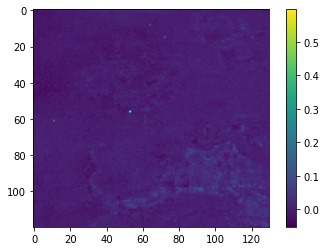

<IPython.core.display.Javascript object>

In [144]:
plt.imshow(perm)
plt.colorbar()
plt.show()

### Make Permutation dummy and embedding

In [145]:
def permutation_feature_importance_last_two(var_num, lead_time):
    """
    Calculate feature importance based on permutations feature importance for last two
    Args:
        var_num: 0 - 5
        lead_time: 0 - 31
        variable: 0 - 12 with order (u10_mean, u10_std, v10_mean, v10_std, t2m_mean ... grid_embedding)
    """
    # Define the names of the variables
    # Define the names of the variables
    var_names = ["u10", "v10", "t2m", "t850", "z500", "ws10"]

    path = f"/Data/Delong_BA_Data/models/DRN_10_dummy/DRN_{var_names[var_num]}_lead_time_{lead_time}_0_denormed_dummy.h5"
    DRN_model = tf.keras.models.load_model(
        path,
        custom_objects={
            "crps_cost_function": crps_cost_function,
            "crps_cost_function_trunc": crps_cost_function_trunc,
        },
    )

    # Add dummy variable for land sea mask
    land_sea_mask_dummy = np.load(
        "/Data/Delong_BA_Data/land_sea_mask_dummy/land_sea_mask_dummy.npy"
    )
    land_sea_mask_input = np.tile(land_sea_mask_dummy.flatten(), 357)
    # Load all test data of each variable
    test_var_denormed = ldpd.load_data_all_test_proc_denorm()

    # Split the loaded data into features (X) and target (y)
    dat_X_test_lead_all_denorm, dat_y_test_lead_all_denorm = split_var_lead(
        test_var_denormed
    )

    # Preprocess the features for Neural Network and scale them
    drn_X_test_lead_array, drn_embedding_test_lead_array = make_X_array(
        dat_X_test_lead_all_denorm, lead_time
    )
    drn_X_test_lead_array_mask = np.column_stack(
        (drn_X_test_lead_array, land_sea_mask_input)
    )
    # Reshape target values into a 1D array
    t2m_y_test = dat_y_test_lead_all_denorm[var_num][lead_time].values.flatten()

    # Load scores:
    DRN_scores_t2m_dummy_10 = DRN_load_score_dummy_10(var_names[var_num])

    # Permutate last two scores:
    # First one:
    perm_values_1 = np.copy(drn_X_test_lead_array_mask)
    perm_values_1[:, 12] = np.random.permutation(drn_X_test_lead_array_mask[:, 12])

    land_sea_permutation_feature_importance_score = (
        DRN_model.evaluate(
            [perm_values_1, drn_embedding_test_lead_array,], t2m_y_test, verbose=0,
        )
        - DRN_scores_t2m_dummy_10[lead_time].mean()
    )

    # Second one:
    perm_values_2 = np.random.permutation(drn_embedding_test_lead_array)
    embedding_permutation_feature_importance_score = (
        DRN_model.evaluate(
            [drn_X_test_lead_array_mask, perm_values_2,], t2m_y_test, verbose=0,
        )
        - DRN_scores_t2m_dummy_10[lead_time].mean()
    )

    return (
        land_sea_permutation_feature_importance_score,
        embedding_permutation_feature_importance_score,
    )

<IPython.core.display.Javascript object>

In [146]:
np.random.permutation(drn_embedding_test_lead_array)

array([13948,  3190,  8616, ..., 14318,  2723,   692])

<IPython.core.display.Javascript object>

In [147]:
drn_embedding_test_lead_array

array([    0,     1,     2, ..., 15597, 15598, 15599])

<IPython.core.display.Javascript object>

In [148]:
(
    land_sea_permutation_feature_importance_score,
    embedding_permutation_feature_importance_score,
) = permutation_feature_importance_last_two(2, 11)

<IPython.core.display.Javascript object>

In [149]:
land_sea_permutation_feature_importance_score

0.6009533648913927

<IPython.core.display.Javascript object>

In [150]:
embedding_permutation_feature_importance_score

0.6186617856448717

<IPython.core.display.Javascript object>